In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

total = pd.read_csv('/content/drive/MyDrive/data/DACON_가스공급량_수요예측_모델개발/train.csv', encoding = 'cp949')
total.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


In [3]:
total['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [4]:
d_map = dict()
for i, d in enumerate(total['구분'].unique()):
  d_map[d] = i
# 라벨 인코딩

total['구분'] = total['구분'].map(d_map)

total

,연월일,시간,구분,공급량
0,2013-01-01,1,0,2497.129
1,2013-01-01,2,0,2363.265
2,2013-01-01,3,0,2258.505
3,2013-01-01,4,0,2243.969
4,2013-01-01,5,0,2344.105
...,...,...,...,...
368083,2018-12-31,20,6,681.033
368084,2018-12-31,21,6,669.961
368085,2018-12-31,22,6,657.941
368086,2018-12-31,23,6,610.953


- 구분을 숫자로 **변경**

In [5]:
total['연월일'] = pd.to_datetime(total['연월일'])

total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

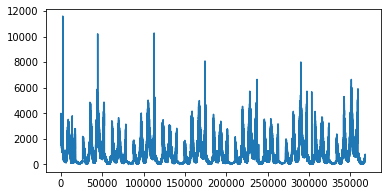

In [81]:
f, ax = plt.subplots(figsize = (6,3))
total['공급량'].plot()

- 시계열 데이터라 그런지 뭔가 일정한 패턴이 있어보인다.

In [6]:
train_years = [2013, 2014, 2015, 2016, 2017]
val_years = [2018] # 시계열 데이터이므로 2018년 1년치의 데이터를 예측, test data set에는 2019년 데이터를 예측

train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text

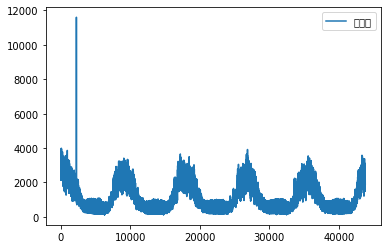

In [96]:
train[train['구분']==0][['공급량']].reset_index(drop = True).plot()
# 이상치가 있다. 어떤 이유인지 모르겠지만 12000가까운 수치는 저 시계열 데이터상 있을 수 없는 일 인거같다.
# 복합적인 이유일 수 있으니 scaler로 제어해보겠다.

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

scaler_num = ['scaler_0','scaler_1','scaler_2','scaler_3','scaler_4','scaler_5','scaler_6']

for i in range(7):
  #scaler = MinMaxScaler()
  
  scaler_num[i] = RobustScaler()
  globals()['train_{}'.format(i)] = scaler_num[i].fit_transform(train[train['구분']==i][['공급량']].reset_index(drop = True))
  globals()['val_{}'.format(i)] = scaler_num[i].transform(val[val['구분']==i][['공급량']].reset_index(drop = True))
  

print(train_0.shape, val_0.shape)

(43824, 1) (8760, 1)


- 딥러닝을 사용할 예정이라서 전체 데이터를 전부 넣어도 무방하지만 모델을 더 돌려보자는 취지에서 각 구분별로 모델정의 즉, 7개의 모델을 생성예정
- 그에 따라 스케일러도 7개 생성

In [8]:
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)

LOOK_BACK = 24

x_train_0, y_train_0 = create_dataset(train_0, LOOK_BACK)
x_val_0, y_val_0 = create_dataset(val_0, LOOK_BACK)

#################################################################

x_train_1, y_train_1 = create_dataset(train_1, LOOK_BACK)
x_val_1, y_val_1 = create_dataset(val_1, LOOK_BACK)

#################################################################

x_train_2, y_train_2 = create_dataset(train_2, LOOK_BACK)
x_val_2, y_val_2 = create_dataset(val_2, LOOK_BACK)

#################################################################

x_train_3, y_train_3 = create_dataset(train_3, LOOK_BACK)
x_val_3, y_val_3 = create_dataset(val_3, LOOK_BACK)

#################################################################

x_train_4, y_train_4 = create_dataset(train_4, LOOK_BACK)
x_val_4, y_val_4 = create_dataset(val_4, LOOK_BACK)

#################################################################

x_train_5, y_train_5 = create_dataset(train_5, LOOK_BACK)
x_val_5, y_val_5 = create_dataset(val_5, LOOK_BACK)

#################################################################

x_train_6, y_train_6 = create_dataset(train_6, LOOK_BACK)
x_val_6, y_val_6 = create_dataset(val_6, LOOK_BACK)

- LOOKBACK을 24로 정하고(시간단위 데이터인데 24시간마다 어떠한 주기가 나타날 것이라고 추측) 데이터변형

In [9]:
from tensorflow.python.keras.callbacks import History
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, GRU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


def create_bilstm(units, x_train):
  inputs = Input(shape = (x_train.shape[1], x_train.shape[2]))
  hidden1 = Bidirectional(LSTM(units = units, return_sequences=True))(inputs)
  hidden2 = Bidirectional(LSTM(units = units))(hidden1)
  output = Dense(1)(hidden2)
  model = Model(inputs = inputs, outputs = output)
  model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_absolute_percentage_error'])

  return model

def create_gru(units, x_train):
  inputs = Input(shape = (x_train.shape[1], x_train.shape[2]))
  hidden1 = GRU(units = units, return_sequences=True)(inputs)
  hidden2 = GRU(units = units)(hidden1)
  output = Dense(1)(hidden2)
  model = Model(inputs = inputs, outputs = output)
  model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_absolute_percentage_error'])

  return model


def fit_model(model,x_train, y_train, epoch, x_val,y_val):
  early_stop = EarlyStopping(monitor = 'val_loss',
                             patience = 10)
  
  history = model.fit(x_train, y_train, 
                      epochs = epoch, 
                      validation_data = (x_val, y_val),
                      batch_size = 64,
                      shuffle = False,
                      callbacks = [early_stop])
  return history



- 양방향 LSTM, GRU를 비교할 예정

In [ ]:
from sklearn.metrics import mean_squared_error

def mape(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

# train_0 학습
model_lstm_0 = create_bilstm(64, x_train_0)
history_lstm_0 = fit_model(model_lstm_0, x_train_0, y_train_0, 50, x_val_0, y_val_0)

y_val_0 = scaler_num[0].inverse_transform(y_val_0)
pred_lstm_0 = scaler_num[0].inverse_transform(model_lstm_0.predict(x_val_0))

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_0, y_val_0)**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_0, y_val_0)))

Epoch 1/50
685/685 [==============================] - 31s 34ms/step - loss: 0.0515 - mean_absolute_percentage_error: 213.4370 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 273.7552
Epoch 2/50
685/685 [==============================] - 22s 32ms/step - loss: 0.0141 - mean_absolute_percentage_error: 129.8848 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 228.8721
Epoch 3/50
685/685 [==============================] - 22s 32ms/step - loss: 0.0118 - mean_absolute_percentage_error: 111.1412 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 257.7822
Epoch 4/50
685/685 [==============================] - 22s 32ms/step - loss: 0.0107 - mean_absolute_percentage_error: 96.6916 - val_loss: 0.0171 - val_mean_absolute_percentage_error: 255.1485
Epoch 5/50
685/685 [==============================] - 22s 32ms/step - loss: 0.0095 - mean_absolute_percentage_error: 88.5317 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 240.8733
Epoch 6/50
685/685 [======================

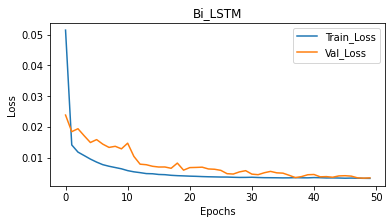

In [ ]:
def loss_vis(history, model_name):
  f, ax = plt.subplots(figsize = (6, 3))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train_Loss', 'Val_Loss'])
  plt.title(model_name)

loss_vis(history_lstm_0, 'Bi_LSTM')

In [69]:
def pred_vis(pred_model, model_name, y_val):
  f, ax = plt.subplots(figsize = (15,8))
  plt.plot(pred_model, label = 'Prediction',  alpha = 0.5)
  plt.plot(y_val, label = 'Val_data',  alpha = 0.3)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.title(model_name)


In [ ]:
# train_1 학습
model_1 = create_bilstm(64, x_train_1)
history_lstm_1 = fit_model(model_1, x_train_1, y_train_1, 70, x_val_1, y_val_1)
print('-'*150)

y_val_1 = scaler_num[1].inverse_transform(y_val_1)
pred_lstm_1 = scaler_num[1].inverse_transform(model_1.predict(x_val_1))

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_1, y_val_1)**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_1, y_val_1)))
print('-'*150)

# train_2 학습
model_2 = create_bilstm(64, x_train_2)
history_lstm_2 = fit_model(model_2, x_train_2, y_train_2, 70, x_val_2, y_val_2)
print('-'*150)

y_val_2 = scaler_num[2].inverse_transform(y_val_2)
pred_lstm_2 = scaler_num[2].inverse_transform(model_2.predict(x_val_2))

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_2, y_val_2)**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_2, y_val_2)))
print('-'*150)

# train_3 학습
model_3 = create_bilstm(64, x_train_3)
history_lstm_3 = fit_model(model_3, x_train_3, y_train_3, 70, x_val_3, y_val_3)
print('-'*150)

y_val_3 = scaler_num[3].inverse_transform(y_val_3)
pred_lstm_3 = scaler_num[3].inverse_transform(model_3.predict(x_val_3))

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_3, y_val_3)**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_3, y_val_3)))
print('-'*150)

Epoch 1/70
685/685 [==============================] - 31s 35ms/step - loss: 0.0463 - mean_absolute_percentage_error: 169.6386 - val_loss: 0.0235 - val_mean_absolute_percentage_error: 248.9355
Epoch 2/70
685/685 [==============================] - 22s 32ms/step - loss: 0.0116 - mean_absolute_percentage_error: 74.7569 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 279.5636
Epoch 3/70
685/685 [==============================] - 22s 32ms/step - loss: 0.0106 - mean_absolute_percentage_error: 75.8301 - val_loss: 0.0231 - val_mean_absolute_percentage_error: 285.4313
Epoch 4/70
685/685 [==============================] - 22s 32ms/step - loss: 0.0097 - mean_absolute_percentage_error: 75.5941 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 255.7267
Epoch 5/70
685/685 [==============================] - 22s 32ms/step - loss: 0.0086 - mean_absolute_percentage_error: 74.3617 - val_loss: 0.0162 - val_mean_absolute_percentage_error: 280.6541
Epoch 6/70
685/685 [========================

In [ ]:
# train_4 학습
model_4 = create_bilstm(64, x_train_4)
history_lstm_4 = fit_model(model_4, x_train_4, y_train_4, 50, x_val_4, y_val_4)

print('-'*150)
y_val_4 = scaler_num[4].inverse_transform(y_val_4)
pred_lstm_4 = scaler_num[4].inverse_transform(model_4.predict(x_val_4))

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_4, y_val_4)**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_4, y_val_4)))
print('-'*150)



# train_5 학습
model_5 = create_bilstm(64, x_train_5)
history_lstm_5 = fit_model(model_5, x_train_5, y_train_5, 50, x_val_5, y_val_5)

print('-'*150)
y_val_5 = scaler_num[5].inverse_transform(y_val_5)
pred_lstm_5 = scaler_num[5].inverse_transform(model_5.predict(x_val_5))

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_5, y_val_5)**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_5, y_val_5)))
print('-'*150)


# train_6 학습
model_6 = create_bilstm(64, x_train_6)
history_lstm_6 = fit_model(model_6, x_train_6, y_train_6, 50, x_val_6, y_val_6)
print('-'*150)

y_val_6 = scaler_num[6].inverse_transform(y_val_6)
pred_lstm_6 = scaler_num[6].inverse_transform(model_6.predict(x_val_6))

print("LSTM의 RMSE : {}".format(mean_squared_error(pred_lstm_6, y_val_6)**0.5),'\n', 'LSTM의 MAPE : {}'.format(mape(pred_lstm_6, y_val_6)))
print('-'*150)


In [ ]:
model_list = [model_lstm_0, model_1, model_2, model_3, model_4, model_5, model_6]
num = 0
for i in model_list:
  i.save('/content/drive/MyDrive/data/DACON_가스공급량_수요예측_모델개발/' + 'model_' + str(num)+'.h5')
  num+=1

- 코랩 무료 gpu의 한계로 모델을 저장하고 불러오는 방법 선택

In [10]:
from tensorflow.keras.models import load_model
model_list = ['model_0', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6']
num = 0

for i in model_list:
  globals()['{}'.format(i)] = load_model('/content/drive/MyDrive/data/DACON_가스공급량_수요예측_모델개발/' + 'model_' + str(num)+'.h5')
  num+=1


In [11]:
from sklearn.metrics import mean_squared_error

def mape(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

y_val_0 = scaler_num[0].inverse_transform(y_val_0)
pred_lstm_0 = scaler_num[0].inverse_transform(model_0.predict(x_val_0))

print('RMSE : {}'.format(mean_squared_error(y_val_0, pred_lstm_0)))

y_val_1 = scaler_num[1].inverse_transform(y_val_1)
pred_lstm_1 = scaler_num[1].inverse_transform(model_1.predict(x_val_1))

print('RMSE : {}'.format(mean_squared_error(y_val_1, pred_lstm_1)**0.5))

y_val_2 = scaler_num[2].inverse_transform(y_val_2)
pred_lstm_2 = scaler_num[2].inverse_transform(model_2.predict(x_val_2))

print('RMSE : {}'.format(mean_squared_error(y_val_2, pred_lstm_2)**0.5))

y_val_3 = scaler_num[3].inverse_transform(y_val_3)
pred_lstm_3 = scaler_num[3].inverse_transform(model_3.predict(x_val_3))

print('RMSE : {}'.format(mean_squared_error(y_val_3, pred_lstm_3)**0.5))

y_val_4 = scaler_num[4].inverse_transform(y_val_4)
pred_lstm_4 = scaler_num[4].inverse_transform(model_4.predict(x_val_4))

print('RMSE : {}'.format(mean_squared_error(y_val_4, pred_lstm_4)**0.5))

y_val_5 = scaler_num[5].inverse_transform(y_val_5)
pred_lstm_5 = scaler_num[5].inverse_transform(model_5.predict(x_val_5))

print('RMSE : {}'.format(mean_squared_error(y_val_5, pred_lstm_5)**0.5))

y_val_6 = scaler_num[6].inverse_transform(y_val_6)
pred_lstm_6 = scaler_num[6].inverse_transform(model_6.predict(x_val_6))

print('RMSE : {}'.format(mean_squared_error(y_val_6, pred_lstm_6)**0.5))


RMSE : 5368.091565276349


In [67]:
y_val_total = (np.concatenate((y_val_0, y_val_1, y_val_2, y_val_3, y_val_4, y_val_5, y_val_6), axis=0))
pred_lstm_total = (np.concatenate((pred_lstm_0, pred_lstm_1, pred_lstm_2, pred_lstm_3, pred_lstm_4, pred_lstm_5, pred_lstm_6), axis=0))

print('RMSE : {}'.format(mean_squared_error(y_val_total, pred_lstm_total)**0.5))
print('MAPE : {}'.format(mape(y_val_total, pred_lstm_total)))

RMSE : 69.98451344074019
MAPE : 17.012626884424094


- 7개의 모델의 결과값을 합쳐서 다시 결과값을 도출해본 결과 RMSE가 약 70으로 생각보다 괜찮게 나왔고 MAPE는 17로 17%의 오차율이 있다.



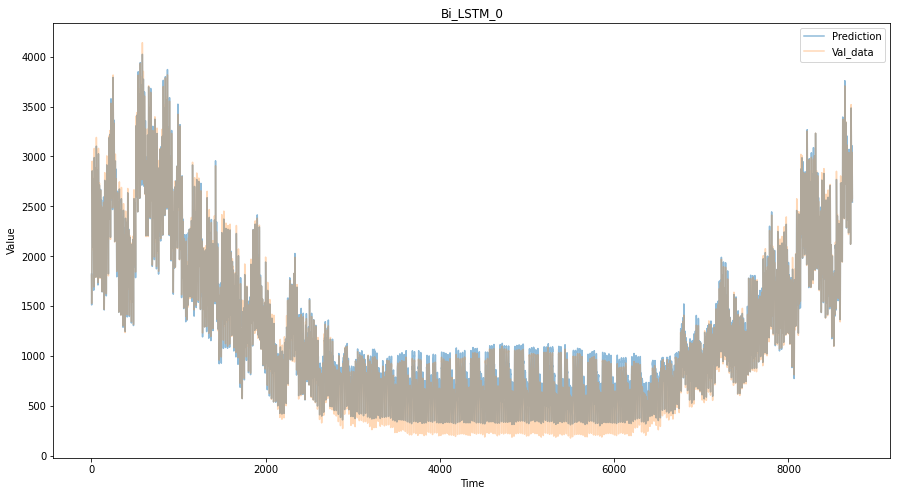

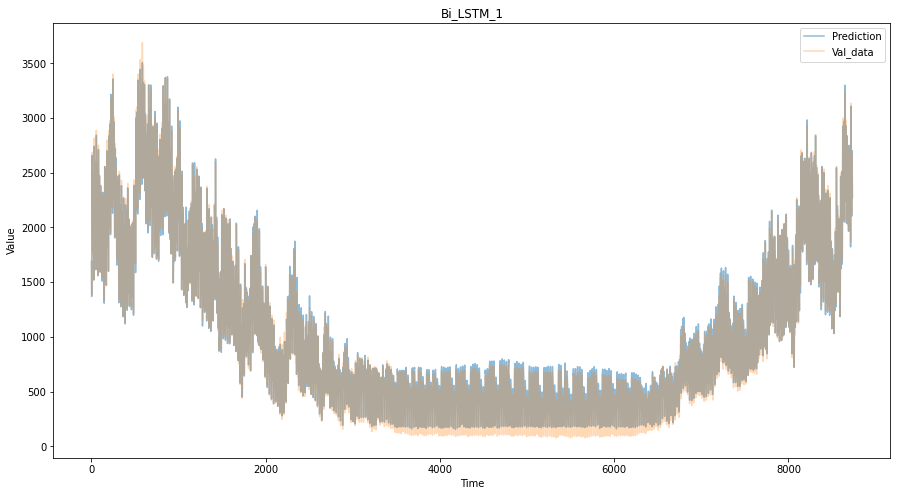

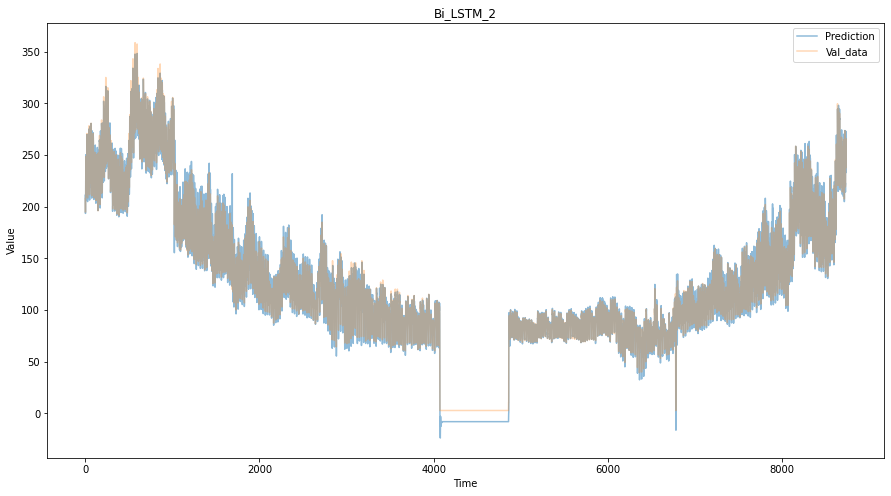

In [74]:
pred_vis(pred_lstm_0, 'Bi_LSTM_0', y_val_0)
pred_vis(pred_lstm_1, 'Bi_LSTM_1', y_val_1)
pred_vis(pred_lstm_2, 'Bi_LSTM_2', y_val_2)

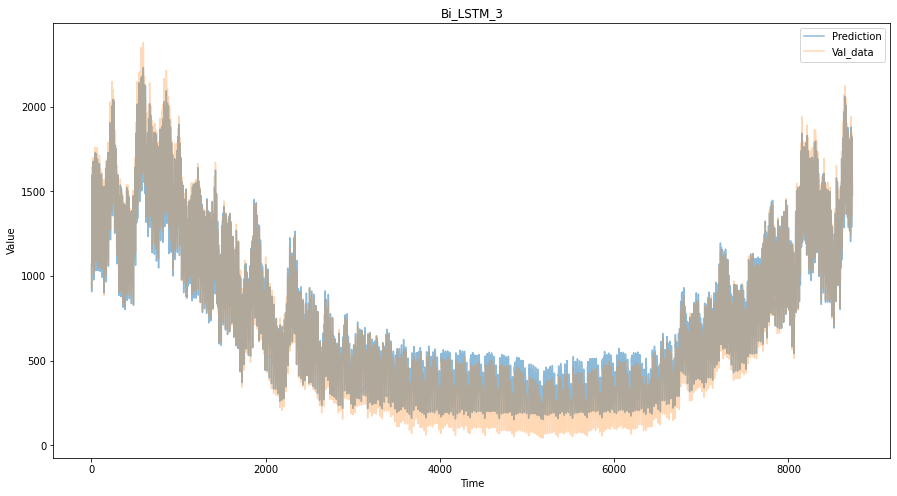

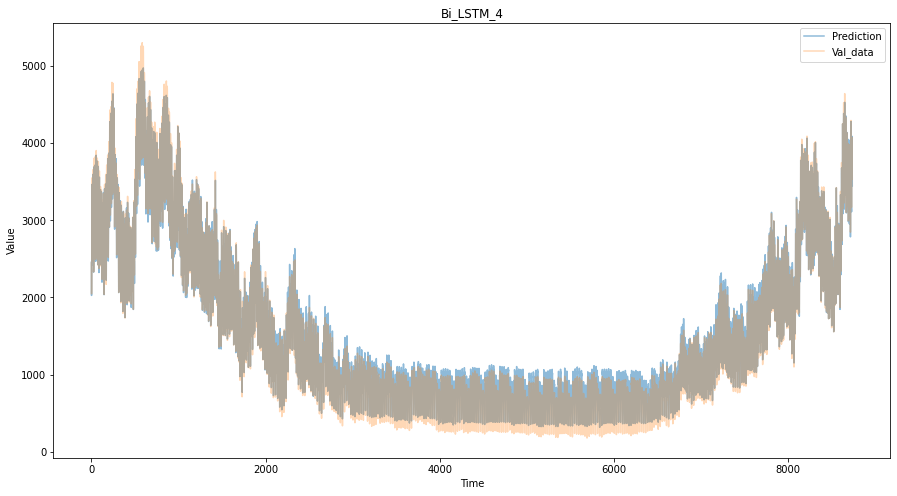

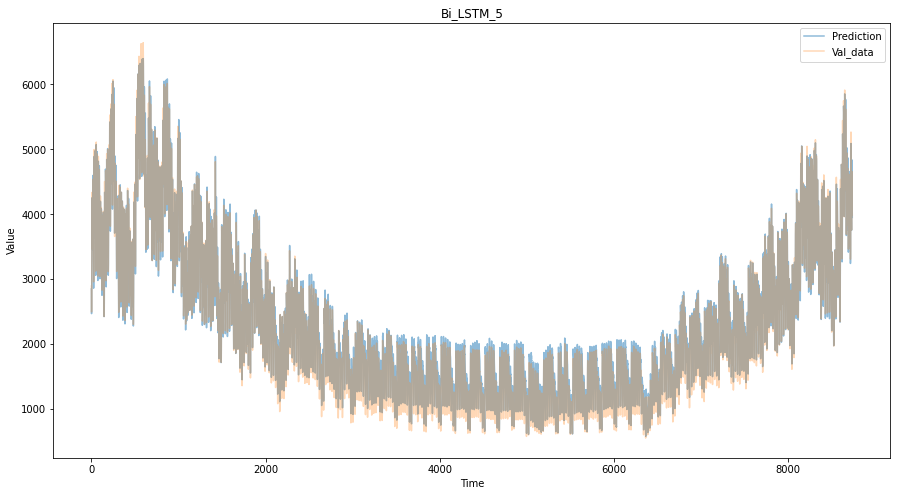

In [78]:
pred_vis(pred_lstm_3, 'Bi_LSTM_3', y_val_3)
pred_vis(pred_lstm_4, 'Bi_LSTM_4', y_val_4)
pred_vis(pred_lstm_5, 'Bi_LSTM_5', y_val_5)

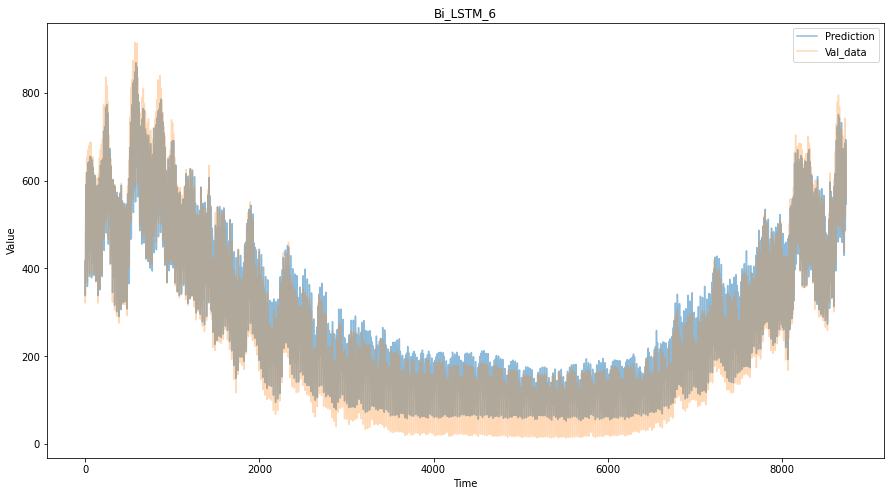

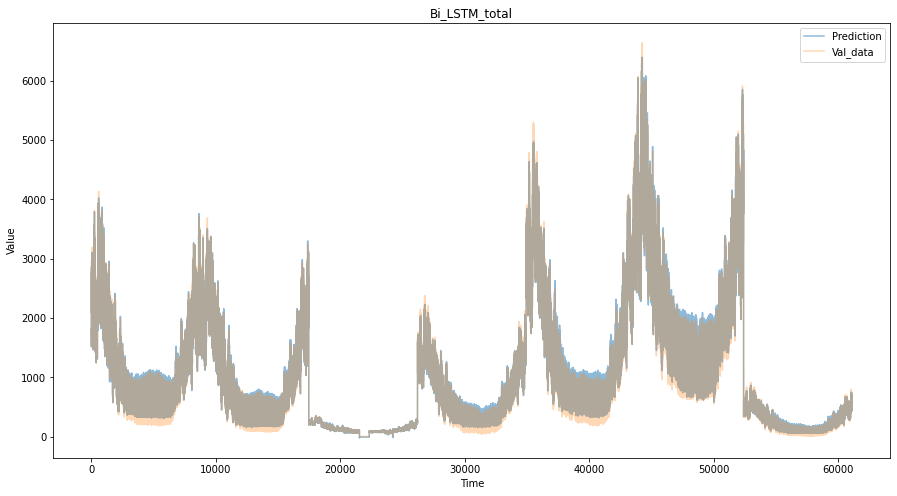

In [77]:
pred_vis(pred_lstm_6, 'Bi_LSTM_6', y_val_6)
pred_vis(pred_lstm_total, 'Bi_LSTM_total', y_val_total)

- 확실히 lgbm baseline보다 잘 나왔다.
- 아주 훌륭한 성능은 아니지만 이정도면 괜찮은거같다. 이상치부분을 처리만 잘하면 더 좋은 성능을 낼 수 있을것 같다.

In [ ]:
# scaling, autoencoder, 4계절로 잘라서 iqr이상치를 평균으로, 아니면 날씨 정보나 다른것들을 찾아보자, feature 추가
# https://velog.io/@nameunzz/Anomaly-Detection#4-auto-encoder

# 수정사항
## 삽질!
## minmax scaling -> robust scaling


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/data/DACON_가스공급량_수요예측_모델개발/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/data/DACON_가스공급량_수요예측_모델개발/sample_submission.csv')